# Images Analysis

In [16]:
import os
import pandas as pd
import json
import monai
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [2]:
figures_dir = '/home/jaalzate/Prostate_Cancer_TFM/Data_Analysis/Figures/Validation'
colors=(
            "#efc86e",
            "#97c684",
            "#6f9969",
            "#aab5d5",
            "#808fe1",
            "#5c66a8",
            "#454a74",
        )

## Plot Functions

In [3]:
def plot_size_variability_plotly(dimensions, means, std_devs, colors, title, save_as_pdf=False):
    x_pos = [str(dimension) for dimension in dimensions]  # Ensure dimensions are string for Plotly

    # Create traces
    trace = go.Bar(
        x=x_pos,
        y=means,
        error_y=dict(
            type='data',  # or 'percent' for percentage-based errors
            array=std_devs,
            visible=True
        ),
        marker_color=colors  # Set bar colors
    )

    # Create layout
    layout = go.Layout(
        #title='Image Size Variability '+title,
        # xaxis=dict(
        #     title='Dimensions'
        # ),
        yaxis=dict(
            title='Size (pixels)'
        ),
        template='plotly_white',  # Use a white background for the plot
        font=dict(
            size=15,  # Only change the font size
            # color and family are omitted to use defaults
        )

    )

    # Create figure and add traces
    fig = go.Figure(data=[trace], layout=layout)

    # Update layout for a tighter appearance and grid lines
    fig.update_layout(
        autosize=False,
        width=1000,  # Custom width, adjust as needed
        height=600,  # Custom height, adjust as needed
        margin=dict(
            l=20,
            r=20,
            b=40,
            t=20,
            pad=0
        ),
        # plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
        # paper_bgcolor='rgba(0,0,0,0)',  # Transparent paper background
        yaxis=dict(gridcolor='rgba(128,128,128,0.5)'),  # Custom grid color (light grey) and transparency
    )

    
    # Show the figure
    fig.show()
    # Save figure as pdf
    if save_as_pdf:
        fig.write_image(os.path.join(figures_dir,"image_size_variability_plotly_"+title+".pdf"))

In [4]:
def plot_variability_plotly_grouped(means, stds, datasets, colors, title,x_ticks,y_axis_title, save_as_pdf=False):
    width = 0.25  # Equivalent to the bar width in Plotly terms

    # Create a figure
    fig = go.Figure()

    # Add bars for each dataset
    for i, dataset in enumerate(datasets):
        means_dataset = means[dataset]
        stds_dataset = stds[dataset]
        x_positions = [x + i * width for x in range(len(x_ticks))]  # Adjust x positions for grouping
        
        fig.add_trace(go.Bar(
            x=x_positions,
            y=means_dataset,
            error_y=dict(
                type='data',  # Specify that the errors are given explicitly
                array=stds_dataset,
                visible=True
            ),
            name=dataset,
            marker_color=colors[i]  # Set the color for each dataset
        ))

    # Update layout for the figure
    fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=[x + width for x in range(len(x_ticks))],  # Position x-ticks in the center of groups
            ticktext=x_ticks,  # Label x-ticks with dimension names
            #title='Dimension'
        ),
        yaxis=dict(
            title=y_axis_title
        ),
        # legend=dict(
        #     title='Ori'
        # ),
        barmode='group',  # Group bars instead of stacking
        width=1000,  # Customizable figure size
        height=600,
        template='plotly_white',  # Use a white background for cleaner appearance
        font=dict(size=20),  # Set global font size
        margin=dict(
            l=20,
            r=20,
            b=40,
            t=20,
            pad=0
        )
    )

    # Show the figure
    fig.show()
    if save_as_pdf:
        fig.write_image(os.path.join(figures_dir,"image_variability_plotly_"+title+".pdf"))

In [5]:
def plot_size_variability(dimensions, means, std_devs, colors, title, save_as_pdf=False):
    

    x_pos = np.arange(len(dimensions))

    #Create plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_pos, means, yerr=std_devs, align='center', capsize=10, color=colors)
    plt.xticks(x_pos, dimensions)
    plt.ylabel('Size (pixels)')
    plt.title('Image Size Variability '+title)
    plt.tight_layout()
    plt.grid(True, alpha=0.15)
    if save_as_pdf:
        plt.savefig(os.path.join(figures_dir,"image_size_variability_"+title+".pdf"))
    plt.show()


In [6]:
def plot_orientation_distribution(orientation_counts):
    orientation_labels = list(orientation_counts.keys())
    orientation_values = list(orientation_counts.values())
    
    # Define colors for the pie chart
    colors = ['lightseagreen', 'gold', 'lightpink', 'lightblue', 'lightgreen', 'violet']

    fig = go.Figure(data=[go.Pie(labels=orientation_labels, values=orientation_values, textinfo='label+percent', insidetextorientation='radial', marker_colors=colors)])
    
    fig.update_layout(
        title_text='Orientation Distribution',
        title_font_size=30,
        #font=dict(size=25, weight='bold'),
        showlegend=True
    )
    
    fig.show()

def plot_separate_orientations(orientation_counts):
    # Assuming orientation_counts is a dictionary like {'Axial': count, 'Coronal': count, 'Sagittal': count}
    subplots_titles = ['Axial', 'Coronal', 'Sagittal']
    colors = ['lightseagreen', 'gold', 'lightpink']  # Colors for each pie chart
    
    fig = go.Figure()

    for i, title in enumerate(subplots_titles):
        fig.add_trace(go.Pie(labels=[title], values=[orientation_counts[title]], name=title, marker_colors=[colors[i]]))
    
    fig.update_traces(textinfo='label+percent', insidetextorientation='radial')
    fig.update_layout(
        title_text='Separate Orientation Distributions',
        title_font_size=30,
        #font=dict(size=25, weight='bold')
    )
    
    # Adjust layout to fit three pie charts
    fig.update_layout(
        grid={'rows': 1, 'columns': 3, 'pattern': 'independent'},
        annotations=[dict(text=text, x=0.5, y=0.5, font_size=20, showarrow=False) for text in subplots_titles]
    )
    
    fig.show()

In [7]:
import os
# Creating  tables
path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]

for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)


In [8]:
t2w_df

,subject,session,image,modality,AccessionNumber,AcquisitionDateTime,AcquisitionMatrixPE,AcquisitionNumber,AcquisitionTime,AngioFlag,...,WindowCenter,WindowWidth,BodyPartExamined,RawImage,PhaseEncodingSteps,PartialFourier,SequenceName,SliceTiming,InversionTime,Contrast/BolusRoute
0,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-3_bp-p_vp-sa...,T2w,000063,2016-07-07T14:52:47.000000,256.0,1,14:52:47.000000,N,...,985,1971,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-6_bp-p_vp-ax...,T2w,000063,2016-07-07T15:02:32.000000,224.0,1,15:02:32.000000,N,...,888,1776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-8_bp-p_vp-ax...,T2w,000063,2016-07-07T15:13:34.000000,224.0,1,15:13:34.000000,N,...,1286,2573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-5_bp-p_vp-sa...,T2w,000066,2017-01-27T15:33:36.000000,256.0,1,15:33:36.000000,N,...,914,1829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-8_bp-p_vp-ax...,T2w,000066,2017-01-27T15:44:32.000000,224.0,1,15:44:32.000000,N,...,960,1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,sub-000003,ses-000003,sub-000003_ses-000003_acq-fse_run-8_bp-a_vp-sa...,T2w,000003,2014-03-07T08:27:39.000000,256.0,1,08:27:39.000000,N,...,660,1320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
492,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-8_bp-a_vp-ax...,T2w,000111,2015-06-24T19:55:41.000000,224.0,1,19:55:41.000000,N,...,865,1731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-5_bp-a_vp-sa...,T2w,000111,2015-06-24T19:43:50.000000,256.0,1,19:43:50.000000,N,...,1132,2264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,sub-000120,ses-000120,sub-000120_ses-000120_acq-fse_run-6_bp-a_vp-sa...,T2w,000120,2014-09-24T08:12:51.000000,256.0,1,08:12:51.000000,N,...,710,1421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Image Size Variability

### T2w

In [9]:
images_paths = t2w_df.copy().apply(lambda x: os.path.join(path, x['subject'], x['session'],'mim-mr','anat', x['image']), axis=1)

# Divide into axial, coronal and sagital images
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    if 'sag' in image_name:
        files['sagital'] = path
    elif 'cor' in image_name:
        files['coronal'] = path
    elif 'ax' in image_name:
        files['axial'] = path
    data_list.append(files)

transforms = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["sagital", "coronal", "axial"],allow_missing_keys=True,image_only=False),
                ]
)

train_ds = monai.data.Dataset(
    data=data_list,
    transform=transforms,
)

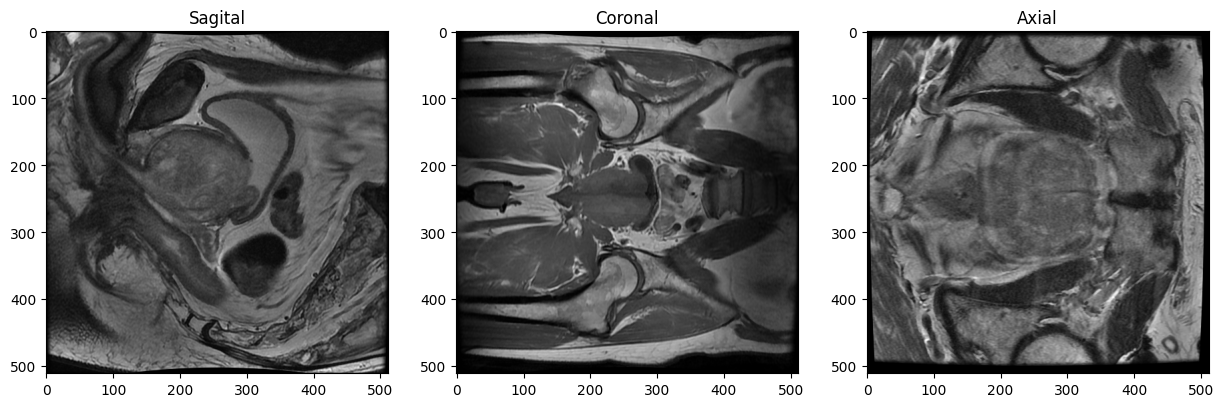

In [10]:
#plot sample images
sagital = train_ds[0]['sagital']
coronal = train_ds[5]['coronal']
axial = train_ds[1]['axial']

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sagital[:, :,12], cmap='gray')
axs[0].set_title('Sagital')

axs[1].imshow(coronal[ :, :,12], cmap='gray')
axs[1].set_title('Coronal')

axs[2].imshow(axial[ :, :,12], cmap='gray')
axs[2].set_title('Axial')

plt.show()

In [6]:
image_sizes_axial = []
image_sizes_coronal = []
image_sizes_sagital = []
for image in tqdm(train_ds):
    if 'sagital' in image.keys():
        image_sizes_sagital.append(list(image['sagital'].shape))
    if 'coronal' in image.keys():
        image_sizes_coronal.append(list(image['coronal'].shape))
    if 'axial' in image.keys():
        image_sizes_axial.append(list(image['axial'].shape))


  0%|          | 0/496 [00:00<?, ?it/s]

In [7]:
widths_axial = [size[0] for size in image_sizes_axial]
heights_axial = [size[1] for size in image_sizes_axial]
depths_axial = [size[2] for size in image_sizes_axial]

widths_coronal = [size[0] for size in image_sizes_coronal]
heights_coronal = [size[1] for size in image_sizes_coronal]
depths_coronal = [size[2] for size in image_sizes_coronal]

widths_sagital = [size[0] for size in image_sizes_sagital]
heights_sagital = [size[1] for size in image_sizes_sagital]
depths_sagital = [size[2] for size in image_sizes_sagital]


In [8]:
mean_width_axial = np.mean(widths_axial)
std_width_axial = np.std(widths_axial)
mean_height_axial = np.mean(heights_axial)
std_height_axial = np.std(heights_axial)
mean_depth_axial = np.mean(depths_axial)
std_depth_axial = np.std(depths_axial)

mean_width_coronal = np.mean(widths_coronal)
std_width_coronal = np.std(widths_coronal)
mean_height_coronal = np.mean(heights_coronal)
std_height_coronal = np.std(heights_coronal)
mean_depth_coronal = np.mean(depths_coronal)
std_depth_coronal = np.std(depths_coronal)

mean_width_sagital = np.mean(widths_sagital)
std_width_sagital = np.std(widths_sagital)
mean_height_sagital = np.mean(heights_sagital)
std_height_sagital = np.std(heights_sagital)
mean_depth_sagital = np.mean(depths_sagital)
std_depth_sagital = np.std(depths_sagital)


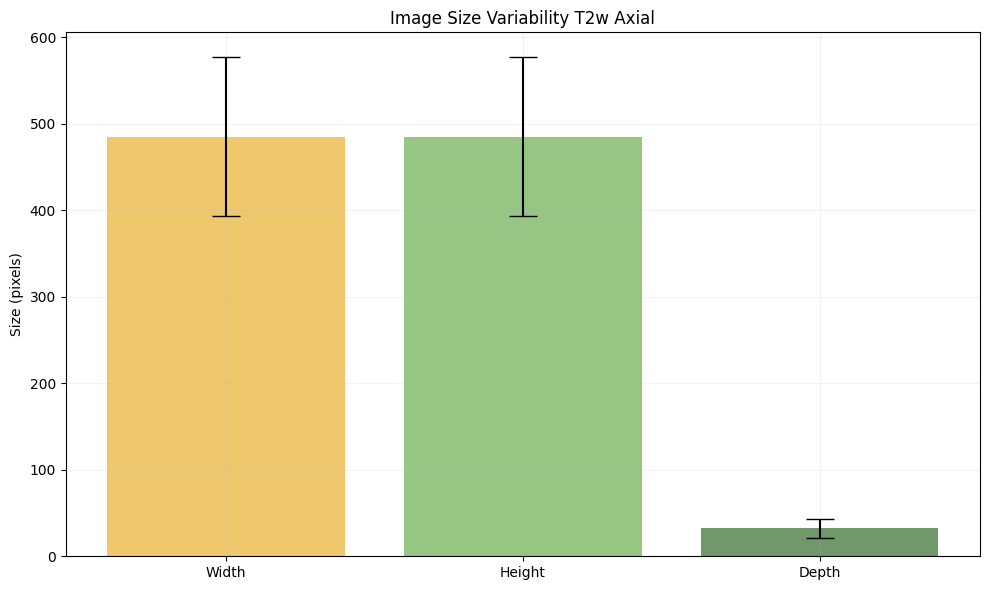

In [70]:
colors=("#efc86e","#97c684","#6f9969","#aab5d5","#808fe1","#5c66a8","#454a74")
plot_size_variability(['Width', 'Height', 'Depth'],
                    [mean_width_axial, mean_height_axial, mean_depth_axial],
                    [std_width_axial, std_height_axial, std_depth_axial], 
                    colors,
                    'T2w Axial',
                    save_as_pdf=True)

In [71]:
plot_size_variability_plotly(['Width', 'Height', 'Depth'],
                            [mean_width_axial, mean_height_axial, mean_depth_axial],
                            [std_width_axial, std_height_axial, std_depth_axial], 
                            colors,
                            'T2w Axial',
                            save_as_pdf=True)

In [72]:
plot_size_variability_plotly(['Width', 'Height', 'Depth'],
                    [mean_width_coronal, mean_height_coronal, mean_depth_coronal],
                    [std_width_coronal, std_height_coronal, std_depth_coronal], 
                    colors,
                    'T2w Coronal',
                    save_as_pdf=True)

In [73]:
plot_size_variability_plotly(['Width', 'Height', 'Depth'],
                    [mean_width_sagital, mean_height_sagital, mean_depth_sagital],
                    [std_width_sagital, std_height_sagital, std_depth_sagital], 
                    colors,
                    'T2w Sagital',
                    save_as_pdf=True)

In [119]:
x_ticks = ['Width', 'Height', 'Depth']  # Base positions for each group of bars
y_axis_title = 'Size (pixels)'
#random order of colors
colors_sub = np.random.choice(colors, 3, replace=False)
plot_variability_plotly_grouped( {'Axial': [mean_width_axial, mean_height_axial, mean_depth_axial],
                                      'Coronal': [mean_width_coronal, mean_height_coronal, mean_depth_coronal],
                                      'Sagital': [mean_width_sagital, mean_height_sagital, mean_depth_sagital]},
                                    {'Axial': [std_width_axial, std_height_axial, std_depth_axial],
                                      'Coronal': [std_width_coronal, std_height_coronal, std_depth_coronal],
                                      'Sagital': [std_width_sagital, std_height_sagital, std_depth_sagital]},
                                    ['Axial', 'Coronal', 'Sagital'],
                                    colors_sub,
                                    'size_T2w_grouped',
                                    x_ticks,
                                    y_axis_title,
                                    save_as_pdf=True)

## In Plane Resolution

### T2w

In [82]:
image_spacings_axial = []
image_spacings_coronal = []
image_spacings_sagital = []

for image in tqdm(train_ds):
    if 'sagital' in image.keys():
        image_spacings_sagital.append(list(image['sagital_meta_dict']['pixdim'][1:4]))
    if 'coronal' in image.keys():
        image_spacings_coronal.append(list(image['coronal_meta_dict']['pixdim'][1:4]))
    if 'axial' in image.keys():
        image_spacings_axial.append(list(image['axial_meta_dict']['pixdim'][1:4]))

  0%|          | 0/496 [00:00<?, ?it/s]

In [84]:
xs_axial = [dim[0] for dim in image_spacings_axial]
ys_axial = [dim[1] for dim in image_spacings_axial]
zs_axial = [dim[2] for dim in image_spacings_axial]

xs_coronal = [dim[0] for dim in image_spacings_coronal]
ys_coronal = [dim[1] for dim in image_spacings_coronal]
zs_coronal = [dim[2] for dim in image_spacings_coronal]

xs_sagital = [dim[0] for dim in image_spacings_sagital]
ys_sagital = [dim[1] for dim in image_spacings_sagital]
zs_sagital = [dim[2] for dim in image_spacings_sagital]

In [85]:
mean_x_axial = np.mean(xs_axial)
std_x_axial = np.std(xs_axial)
mean_y_axial = np.mean(ys_axial)
std_y_axial = np.std(ys_axial)
mean_z_axial = np.mean(zs_axial)
std_z_axial = np.std(zs_axial)

mean_x_coronal = np.mean(xs_coronal)
std_x_coronal = np.std(xs_coronal)
mean_y_coronal = np.mean(ys_coronal)
std_y_coronal = np.std(ys_coronal)
mean_z_coronal = np.mean(zs_coronal)
std_z_coronal = np.std(zs_coronal)

mean_x_sagital = np.mean(xs_sagital)
std_x_sagital = np.std(xs_sagital)
mean_y_sagital = np.mean(ys_sagital)
std_y_sagital = np.std(ys_sagital)
mean_z_sagital = np.mean(zs_sagital)
std_z_sagital = np.std(zs_sagital)

In [126]:
import random
x_ticks = ['X', 'Y', 'Z']  # Base positions for each group of bars
y_axis_title = 'Spacing (mm)'
colors_sub = np.random.choice(colors, 3, replace=False)
plot_variability_plotly_grouped( {'Axial': [mean_x_axial, mean_y_axial, mean_z_axial],
                                'Coronal': [mean_x_coronal, mean_y_coronal, mean_z_coronal],
                                'Sagital': [mean_x_sagital, mean_y_sagital, mean_z_sagital]},
                                {'Axial': [std_x_axial, std_y_axial, std_z_axial],
                                'Coronal': [std_x_coronal, std_y_coronal, std_z_coronal],
                                'Sagital': [std_x_sagital, std_y_sagital, std_z_sagital]},
                                ['Axial', 'Coronal', 'Sagital'],
                                colors_sub,
                                'spacing_T2w_grouped',
                                x_ticks,
                                y_axis_title,
                                save_as_pdf=True)

## Orientation

### T2w

In [127]:
image_orientation_axial = []
image_orientation_coronal = []
image_orientation_sagital = []

for image in tqdm(train_ds):
    if 'sagital' in image.keys():
        image_orientation_sagital.append(image['sagital_meta_dict']['space'])
    if 'coronal' in image.keys():
        image_orientation_coronal.append(image['coronal_meta_dict']['space'])
    if 'axial' in image.keys():
        image_orientation_axial.append(image['axial_meta_dict']['space'])

  0%|          | 0/496 [00:00<?, ?it/s]

In [131]:
orientation_counts_axial = {str(orientation): image_orientation_axial.count(orientation) for orientation in set(image_orientation_axial)}
orientation_counts_coronal = {str(orientation): image_orientation_coronal.count(orientation) for orientation in set(image_orientation_coronal)}
orientation_counts_sagital = {str(orientation): image_orientation_sagital.count(orientation) for orientation in set(image_orientation_sagital)}

In [142]:
plot_orientation_distribution(orientation_counts_sagital)

## Image Intensities

### T2w

In [40]:
def sample_intensities(image, sample_size=1000):
    """Sample a fixed number of pixels from an image."""
    flattened = image.flatten()
    sampled_indices = np.random.choice(len(flattened), size=sample_size, replace=False)
    return flattened[sampled_indices].mean()

intensity_values_axial = []
intensity_values_coronal = []
intensity_values_sagital = []

for image in tqdm(train_ds):
    if 'sagital' in image.keys():
        intensity_values_sagital.append(sample_intensities(image['sagital']))
    if 'coronal' in image.keys():
        intensity_values_coronal.append(sample_intensities(image['coronal']))
    if 'axial' in image.keys():
        intensity_values_axial.append(sample_intensities(image['axial']))

100%|██████████| 496/496 [02:29<00:00,  3.32it/s]


In [44]:
def plot_intensity_histograms_subplots(intensity_values_axial, intensity_values_coronal, intensity_values_sagittal,colors,bins=50):
    # Create a 3x1 subplot layout
    fig = make_subplots(rows=3, cols=1, subplot_titles=('Axial Orientation', 'Coronal Orientation', 'Sagittal Orientation'))
    
    # Axial histogram
    fig.add_trace(
        go.Histogram(x=intensity_values_axial, name='Axial', marker_color=colors[0], nbinsx=bins),
        row=1, col=1
    )
    
    # Coronal histogram
    fig.add_trace(
        go.Histogram(x=intensity_values_coronal, name='Coronal', marker_color=colors[1], nbinsx=bins),
        row=2, col=1
    )
    
    # Sagittal histogram
    fig.add_trace(
        go.Histogram(x=intensity_values_sagittal, name='Sagittal', marker_color=colors[2], nbinsx=bins),
        row=3, col=1
    )
    
    # Update layout for the figure
    fig.update_layout(
        title_text='Histogram of Image Intensities by Orientation',
        title_font_size=20,
        template='plotly_white',  # Use a white background for cleaner appearance
        font=dict(size=18),
        height=900  # Adjust height to accommodate three subplots
    )
    
    # Update x-axis and y-axis labels
    fig.update_xaxes(title_text='Intensity', row=3, col=1)
    fig.update_yaxes(title_text='Frequency', col=1)

    fig.show()
def plot_intensity_boxplots_subplots(intensity_values_axial, intensity_values_coronal, intensity_values_sagittal,colors):
    # Create a 1x3 subplot layout
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Axial', 'Coronal', 'Sagittal'))
    
    # Axial boxplot
    fig.add_trace(
        go.Box(y=intensity_values_axial, name='Axial', marker_color=colors[0], boxmean='sd'), # boxmean='sd' shows the mean and standard deviation
        row=1, col=1
    )
    
    # Coronal boxplot
    fig.add_trace(
        go.Box(y=intensity_values_coronal, name='Coronal', marker_color=colors[1], boxmean='sd'),
        row=1, col=2
    )
    
    # Sagittal boxplot
    fig.add_trace(
        go.Box(y=intensity_values_sagittal, name='Sagittal', marker_color=colors[2], boxmean='sd'),
        row=1, col=3
    )
    
    # Update layout for the figure
    fig.update_layout(
        title_text='Boxplot of Image Intensities by Orientation',
        title_font_size=20,
        template='plotly_white',  # Use a white background for cleaner appearance
        font=dict(size=18),
        height=600,  # Adjust height as needed
        width=1000  # Adjust width to accommodate three subplots
    )
    
    fig.show()

In [47]:
colors_sub = np.random.choice(colors, 3, replace=False)
plot_intensity_histograms_subplots(intensity_values_axial, intensity_values_coronal, intensity_values_sagital,colors_sub,bins=50)

In [48]:
plot_intensity_boxplots_subplots(intensity_values_axial, intensity_values_coronal, intensity_values_sagital,colors_sub)

In [26]:
import numpy as np
from tqdm import tqdm

def compute_histogram(image, bins=10):
    """Compute the histogram of an image."""
    histogram, _ = np.histogram(image.flatten(), bins=bins)
    return histogram

def average_histograms(histograms):
    """Average a list of histograms."""
    return np.mean(histograms, axis=0)

# Initialize lists to hold histograms for each orientation
histograms_axial = []
histograms_coronal = []
histograms_sagital = []

# Loop through your dataset
for image in tqdm(train_ds):
    if 'sagital' in image.keys():
        histograms_sagital.append(compute_histogram(image['sagital']))
    if 'coronal' in image.keys():
        histograms_coronal.append(compute_histogram(image['coronal']))
    if 'axial' in image.keys():
        histograms_axial.append(compute_histogram(image['axial']))

# Average the histograms for each orientation
avg_histogram_axial = average_histograms(histograms_axial)
avg_histogram_coronal = average_histograms(histograms_coronal)
avg_histogram_sagital = average_histograms(histograms_sagital)




  0%|          | 0/496 [00:00<?, ?it/s]

100%|██████████| 496/496 [01:32<00:00,  5.36it/s]


In [29]:
histograms_sagital

[array([1174382, 2142092, 2110083,  737164,   96539,   24184,    4818,
           1784,     399,      11]),
 array([ 394842, 1139416, 1289498,  723884,   97825,   16935,    5428,
           1902,     277,       9]),
 array([ 767046, 2345612, 2637364, 1365827,  179898,   30400,   10641,
           2872,     358,      14]),
 array([1687198, 2296205, 1571965,  464693,  193496,   48474,   20402,
           7314,    1601,     108]),
 array([ 603392, 1253024, 1409207, 1282494,  978932,  572121,  172047,
          19070,    1131,      38]),
 array([ 625729,  682441,  473872,  552392, 1210858,  801069,   86562,
          20957,    2342,     226]),
 array([ 614082,  671685,  488578,  591035, 1198115,  778637,   92150,
          19620,    2343,     203]),
 array([ 605977, 1141687, 1222646, 2290967,  929510,   84949,   12982,
           2362,     330,      46]),
 array([3473895, 1171364, 1203252, 1560746,  571324,  134514,   10820,
            388,     112,      49]),
 array([1097596, 1807288, 22

In [39]:
def plot_average_histograms_plotly(avg_histogram_axial, avg_histogram_coronal, avg_histogram_sagital, bins=10):
    # Create x values for histogram bins (midpoints of bins)
    x_values = list(range(bins))
    
    # Create traces for each orientation
    trace_axial = go.Scatter(x=x_values, y=avg_histogram_axial, mode='lines', name='Axial', line=dict(color='blue'))
    trace_coronal = go.Scatter(x=x_values, y=avg_histogram_coronal, mode='lines', name='Coronal', line=dict(color='red'))
    trace_sagital = go.Scatter(x=x_values, y=avg_histogram_sagital, mode='lines', name='Sagital', line=dict(color='green'))
    
    # Combine traces in a list
    data = [trace_axial, trace_coronal, trace_sagital]
    
    # Define layout
    layout = go.Layout(
        title='Average Intensity Histograms by Orientation',
        xaxis=dict(title='Intensity Value'),
        yaxis=dict(title='Frequency'),
        template='plotly_white'
    )
    
    # Create figure and add traces
    fig = go.Figure(data=data, layout=layout)
    
    # Show plot
    fig.show()

# Example usage of the function
plot_average_histograms_plotly(avg_histogram_axial, avg_histogram_coronal, avg_histogram_sagital)

In [37]:
x_values = list(range(10))

In [38]:
x_values

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [28]:
avg_histogram_axial

array([2.29735198e+06, 1.71544830e+06, 1.34794797e+06, 1.19527178e+06,
       6.90923662e+05, 3.10122782e+05, 5.79161852e+04, 1.05197778e+04,
       3.44864815e+03, 2.32925926e+02])

# Clinical Variables

# Labels